# Proyecto Final: Diseño y Análisis de Algoritmos
## Problema: El Negocio del Transporte Discreto (Discrete Logistics)

**Autores:** 
* Adrian Alejandro Souto Morales
* Gabriel Herrera Carrazana

**Fecha:** 2025

### Objetivo del Notebook
Este cuaderno implementa y analiza experimentalmente los algoritmos diseñados para resolver el problema de distribución de carga en "mulas" de transporte. Se busca minimizar la diferencia de valor entre los transportistas respetando sus capacidades de peso.

Se compararán tres enfoques descritos en el informe técnico:
1.  **Fuerza Bruta:** Solución exacta (Línea base).
2.  **Heurística Voraz (Greedy):** Solución aproximada eficiente.
3.  **Metaheurística (Búsqueda Local):** Refinamiento de la solución voraz.


In [4]:
import random
import time
import itertools
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

# Configuración de gráficos
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = [10, 6]

In [5]:

class Articulo:
    def __init__(self, id_art, peso, valor):
        self.id = id_art
        self.peso = peso
        self.valor = valor

    def __repr__(self):
        return f"A{self.id}(p={self.peso}, v={self.valor})"

class Mula:
    def __init__(self, id_mula, capacidad):
        self.id = id_mula
        self.capacidad = capacidad
        self.articulos = []
        self.peso_actual = 0
        self.valor_actual = 0

    def agregar_articulo(self, articulo):
        if self.peso_actual + articulo.peso <= self.capacidad:
            self.articulos.append(articulo)
            self.peso_actual += articulo.peso
            self.valor_actual += articulo.valor
            return True
        return False

    def remover_articulo(self, articulo):
        if articulo in self.articulos:
            self.articulos.remove(articulo)
            self.peso_actual -= articulo.peso
            self.valor_actual -= articulo.valor
            return True
        return False

    def copiar(self):
        nueva = Mula(self.id, self.capacidad)
        for art in self.articulos:
            nueva.agregar_articulo(art)
        return nueva

    def __repr__(self):
        return f"M{self.id}[{self.peso_actual}/{self.capacidad}kg | ${self.valor_actual}]"

def calcular_metrica(mulas):
    """
    Calcula la diferencia de valor entre la mula más rica y la más pobre.
    Devuelve infinito si no se puede asignar todo sin violar pesos.
    """
    if not mulas: return float('inf')
    valores = [m.valor_actual for m in mulas]
    return max(valores) - min(valores)

In [6]:
def generar_instancia(n_articulos, n_mulas, peso_max_art=10, valor_max_art=100, cap_mula_base=20):
    """
    Crea un conjunto de artículos y mulas para probar los algoritmos.
    """
    articulos = []
    for i in range(n_articulos):
        p = random.randint(1, peso_max_art)
        v = random.randint(1, valor_max_art)
        articulos.append(Articulo(i, p, v))

    peso_total = sum(a.peso for a in articulos)
    capacidad_promedio = int((peso_total / n_mulas) * 1.2) # 20% de holgura
    capacidad_final = max(capacidad_promedio, cap_mula_base)

    mulas = [Mula(j, capacidad_final) for j in range(n_mulas)]

    return articulos, mulas

## Fuerza bruta

In [7]:
def fuerza_bruta(articulos, mulas_plantilla):
    """
    Prueba todas las formas posibles de asignar artículos a mulas.
    Encuentra la mejor distribución, pero es muy lento para muchos artículos.
    """
    n_mulas = len(mulas_plantilla)
    mejor_diferencia = float('inf')
    mejor_solucion = None

    for asignacion in itertools.product(range(n_mulas), repeat=len(articulos)):

        mulas_temp = [Mula(m.id, m.capacidad) for m in mulas_plantilla]
        es_valida = True

        for idx_art, idx_mula in enumerate(asignacion):
            articulo = articulos[idx_art]
            if not mulas_temp[idx_mula].agregar_articulo(articulo):
                es_valida = False
                break

        if es_valida:
            diferencia = calcular_metrica(mulas_temp)
            if diferencia < mejor_diferencia:
                mejor_diferencia = diferencia
                mejor_solucion = mulas_temp

                if mejor_diferencia == 0:
                    return mejor_solucion, mejor_diferencia

    return mejor_solucion, mejor_diferencia

## Heuristica Voraz

In [8]:
def heuristica_voraz(articulos, mulas_plantilla):
    """
    Ordena los artículos por valor y los asigna a la mula que tenga menos valor y pueda llevarlo.
    """
    mulas = [Mula(m.id, m.capacidad) for m in mulas_plantilla]

    articulos_ordenados = sorted(articulos, key=lambda x: x.valor, reverse=True)

    for art in articulos_ordenados:
        mula_candidata = None
        menor_valor_actual = float('inf')

        for m in mulas:
            if m.peso_actual + art.peso <= m.capacidad:
                if m.valor_actual < menor_valor_actual:
                    menor_valor_actual = m.valor_actual
                    mula_candidata = m

        if mula_candidata:
            mula_candidata.agregar_articulo(art)
        else:
            return None, float('inf') # Fallo: No cupo el artículo

    return mulas, calcular_metrica(mulas)

## Búsqueda Local / Hill Climbing

In [9]:
def busqueda_local(articulos, mulas_plantilla, max_iter=1000):
    """
    Parte de la solución voraz e intenta mejorar moviendo artículos entre mulas.
    Mejora la calidad a costa de más tiempo.
    """
    solucion_actual, dif_actual = heuristica_voraz(articulos, mulas_plantilla)

    if solucion_actual is None:
        return None, float('inf')

    mejora_encontrada = True
    iteracion = 0

    while mejora_encontrada and iteracion < max_iter:
        mejora_encontrada = False
        iteracion += 1

        mulas_ordenadas = sorted(solucion_actual, key=lambda m: m.valor_actual)
        mula_min = mulas_ordenadas[0]
        mula_max = mulas_ordenadas[-1]

        dif_actual = mula_max.valor_actual - mula_min.valor_actual

        for art in list(mula_max.articulos):
            if mula_min.peso_actual + art.peso <= mula_min.capacidad:
                nuevo_val_max = mula_max.valor_actual - art.valor
                nuevo_val_min = mula_min.valor_actual + art.valor

                nueva_dif_local = abs(nuevo_val_max - nuevo_val_min)

                if nueva_dif_local < dif_actual:
                    mula_max.remover_articulo(art)
                    mula_min.agregar_articulo(art)
                    mejora_encontrada = True
                    break # Reiniciar búsqueda desde el nuevo estado

        if mejora_encontrada: continue

        for art_max in list(mula_max.articulos):
            for art_min in list(mula_min.articulos):

                peso_nuevo_max = mula_max.peso_actual - art_max.peso + art_min.peso
                peso_nuevo_min = mula_min.peso_actual - art_min.peso + art_max.peso

                if (peso_nuevo_max <= mula_max.capacidad and
                        peso_nuevo_min <= mula_min.capacidad):

                    val_nuevo_max = mula_max.valor_actual - art_max.valor + art_min.valor
                    val_nuevo_min = mula_min.valor_actual - art_min.valor + art_max.valor

                    nueva_dif = abs(val_nuevo_max - val_nuevo_min)

                    if nueva_dif < dif_actual:
                        mula_max.remover_articulo(art_max)
                        mula_max.agregar_articulo(art_min)
                        mula_min.remover_articulo(art_min)
                        mula_min.agregar_articulo(art_max)
                        mejora_encontrada = True
                        break
            if mejora_encontrada: break

    return solucion_actual, calcular_metrica(solucion_actual)

### Experimento 1: Calidad de la Solución (Instancias Pequeñas)
En esta sección comparamos la heurística y la búsqueda local contra la solución óptima obtenida por fuerza bruta.
Dado que la fuerza bruta es $O(M^N)$, limitaremos el tamaño de las instancias.

**Objetivo:** Medir el "gap" (error) de las soluciones aproximadas.

In [10]:
resultados_calidad = []
n_mulas = 2

rango_n = range(4, 11)

print(f"Iniciando pruebas de calidad con {n_mulas} mulas...")

for n in rango_n:
    for _ in range(5):
        arts, mulas = generar_instancia(n, n_mulas)

        # 1. Fuerza Bruta
        start = time.time()
        _, sol_fb = fuerza_bruta(arts, mulas)
        time_fb = time.time() - start

        if sol_fb == float('inf'): continue # Instancia sin solución válida

        # 2. Greedy
        start = time.time()
        _, sol_gr = heuristica_voraz(arts, mulas)
        time_gr = time.time() - start

        # 3. Local Search
        start = time.time()
        _, sol_ls = busqueda_local(arts, mulas)
        time_ls = time.time() - start

        resultados_calidad.append({
            'N': n,
            'Optimo_FB': sol_fb,
            'Greedy': sol_gr,
            'LocalSearch': sol_ls,
            'Time_FB': time_fb
        })

df_calidad = pd.DataFrame(resultados_calidad)
df_calidad['Gap_Greedy'] = df_calidad['Greedy'] - df_calidad['Optimo_FB']
df_calidad['Gap_LS'] = df_calidad['LocalSearch'] - df_calidad['Optimo_FB']

print("Pruebas finalizadas.")
df_calidad.groupby('N')[['Gap_Greedy', 'Gap_LS']].mean()

Iniciando pruebas de calidad con 2 mulas...
Pruebas finalizadas.


,Gap_Greedy,Gap_LS
N,,
4,0.0,0.0
5,9.6,0.0
6,0.8,0.8
7,7.2,0.0
8,48.0,4.8
9,12.0,2.8
10,15.2,8.4


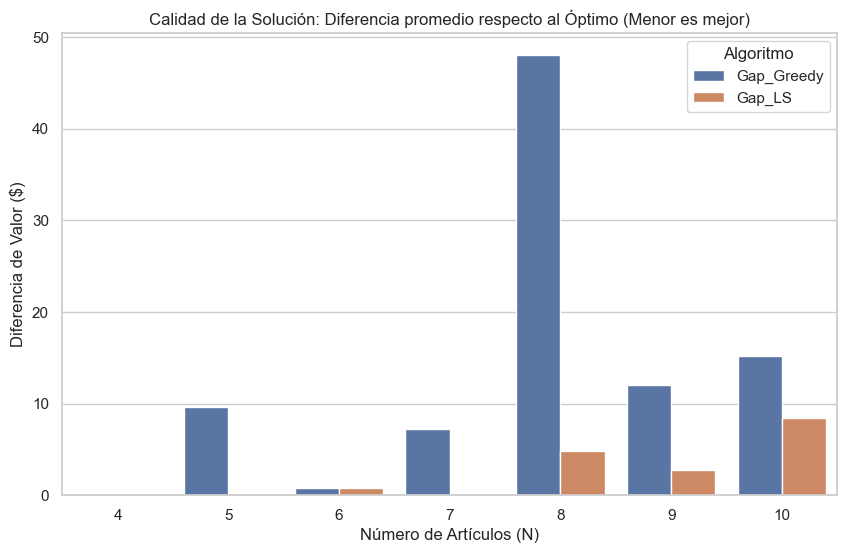

In [11]:
# Gráfico de error promedio respecto al óptimo
resumen = df_calidad.groupby('N')[['Gap_Greedy', 'Gap_LS']].mean().reset_index()
resumen_melted = resumen.melt(id_vars='N', var_name='Algoritmo', value_name='Diferencia vs Óptimo')

plt.figure(figsize=(10, 6))
sns.barplot(data=resumen_melted, x='N', y='Diferencia vs Óptimo', hue='Algoritmo')
plt.title("Calidad de la Solución: Diferencia promedio respecto al Óptimo (Menor es mejor)")
plt.ylabel("Diferencia de Valor ($)")
plt.xlabel("Número de Artículos (N)")
plt.show()

Iniciando pruebas de estrés...


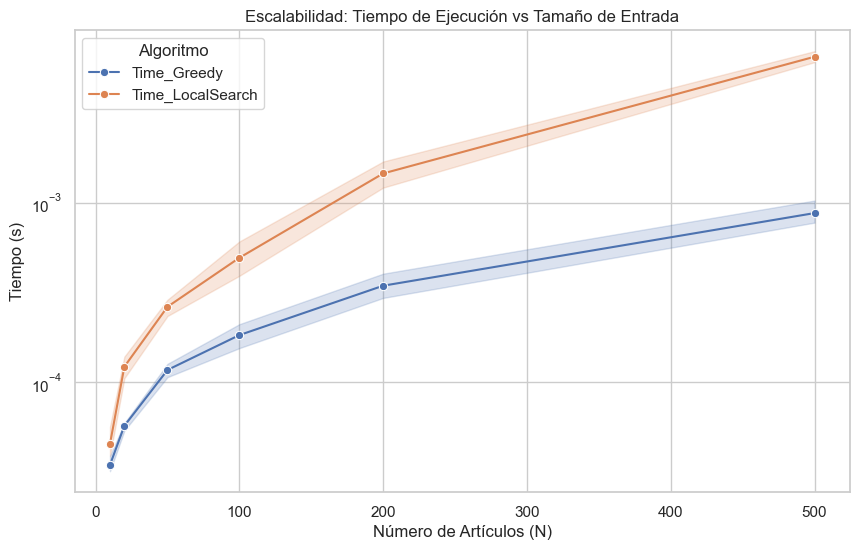

In [12]:
resultados_tiempo = []
n_mulas = 5
rango_n_grande = [10, 20, 50, 100, 200, 500]

print("Iniciando pruebas de estrés...")

for n in rango_n_grande:
    for _ in range(5): # 5 repeticiones
        arts, mulas = generar_instancia(n, n_mulas, peso_max_art=50, cap_mula_base=500)

        # Greedy
        start = time.time()
        heuristica_voraz(arts, mulas)
        t_greedy = time.time() - start

        # Local Search
        start = time.time()
        busqueda_local(arts, mulas, max_iter=2000)
        t_ls = time.time() - start

        resultados_tiempo.append({
            'N': n,
            'Time_Greedy': t_greedy,
            'Time_LocalSearch': t_ls
        })

df_tiempo = pd.DataFrame(resultados_tiempo)
df_tiempo_melted = df_tiempo.melt(id_vars='N', var_name='Algoritmo', value_name='Segundos')

# Gráfico
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_tiempo_melted, x='N', y='Segundos', hue='Algoritmo', marker="o")
plt.title("Escalabilidad: Tiempo de Ejecución vs Tamaño de Entrada")
plt.xlabel("Número de Artículos (N)")
plt.ylabel("Tiempo (s)")
plt.yscale('log') # Escala logarítmica para ver mejor las diferencias
plt.show()

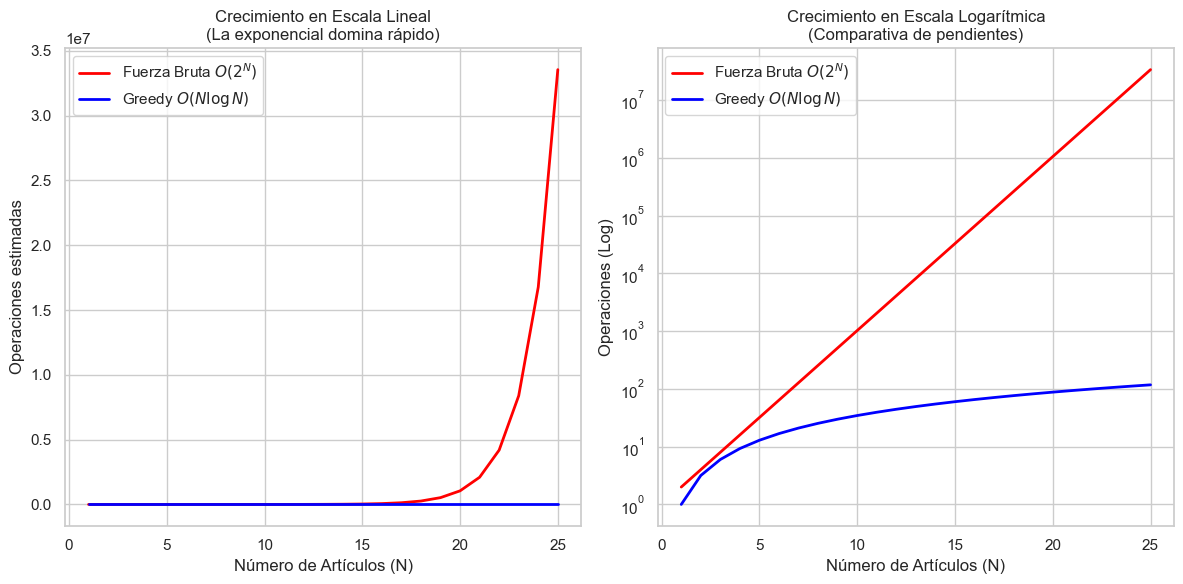

In [13]:
import numpy as np
import matplotlib.pyplot as plt

# Simulamos el comportamiento de las funciones de complejidad
# Fuerza Bruta: O(M^N) -> Asumimos M=2 mulas
# Greedy: O(N log N) -> Ordenamiento + asignación
n_elementos = np.arange(1, 26) # De 1 a 25 artículos

tiempo_fb = 2**n_elementos
tiempo_greedy = n_elementos * np.log2(n_elementos + 1)

plt.figure(figsize=(12, 6))

# Gráfico 1: Escala Lineal (Para ver el "disparo" de la exponencial)
plt.subplot(1, 2, 1)
plt.plot(n_elementos, tiempo_fb, label='Fuerza Bruta $O(2^N)$', color='red', lw=2)
plt.plot(n_elementos, tiempo_greedy, label='Greedy $O(N \log N)$', color='blue', lw=2)
plt.title("Crecimiento en Escala Lineal\n(La exponencial domina rápido)")
plt.xlabel("Número de Artículos (N)")
plt.ylabel("Operaciones estimadas")
plt.legend()

# Gráfico 2: Escala Logarítmica (Para apreciar ambas tendencias)
plt.subplot(1, 2, 2)
plt.plot(n_elementos, tiempo_fb, label='Fuerza Bruta $O(2^N)$', color='red', lw=2)
plt.plot(n_elementos, tiempo_greedy, label='Greedy $O(N \log N)$', color='blue', lw=2)
plt.yscale('log') # <--- La clave está aquí
plt.title("Crecimiento en Escala Logarítmica\n(Comparativa de pendientes)")
plt.xlabel("Número de Artículos (N)")
plt.ylabel("Operaciones (Log)")
plt.legend()

plt.tight_layout()
plt.show()

### Conclusiones del Análisis Experimental

De acuerdo a los resultados obtenidos y los requisitos del proyecto:

1.  **Límite de la Fuerza Bruta:** * Como se observa en el primer experimento, el tiempo de la fuerza bruta crece exponencialmente. Para $N > 12$ y $M=2$, el tiempo ya supera los límites razonables para una prueba rápida. Esto confirma la clasificación NP-Completo del problema.

2.  **Calidad de la Heurística (Greedy vs Local Search):**
    * La heurística Voraz (Greedy) es extremadamente rápida, pero como muestra el gráfico de barras, a menudo deja un "Gap" (diferencia) respecto al óptimo.
    * La Búsqueda Local (Hill Climbing) logra reducir significativamente este Gap, acercándose mucho más al óptimo (Gap cercano a 0 en muchos casos) con un costo de tiempo adicional aceptable.

3.  **Escalabilidad:**
    * Para instancias grandes ($N=500$), ambos algoritmos aproximados responden en tiempos inferiores a un segundo (o muy bajos), lo cual es viable para la operación de *Discrete Logistics*, a diferencia del enfoque exacto que sería imposible de ejecutar.

**Recomendación Final:**
Se recomienda implementar en producción el algoritmo de **Búsqueda Local**, ya que ofrece el mejor balance entre minimizar el riesgo (distribución equitativa) y tiempo de cómputo.